In [370]:
import pandas as pd
import numpy as np
from pathlib import Path

import getpass
pd.options.mode.chained_assignment = None

In [371]:
# Ruta para pcs
user = getpass.getuser() # Capturo el usuario local / Ejemplo "Llan_", este es el nombre de mi usuario que inicie sesion en la pc

if   user== "analistaup29": # PC Analista UP 29 Minedu
     work = Path(r"C:\Users\ANALISTAUP29\OneDrive - Ministerio de Educación\MINEDU_2022\RACIO")
elif user== "llan_": # PC casa Llan
     work = Path(r"C:\Users\llan_\OneDrive - Ministerio de Educación\MINEDU_2022\RACIO")
elif user == "USUARIO": # @hugoferquiroz casa
     work =  Path(r'D:\\Trabajo\AITeacherAllocation') 

In [372]:
df = pd.read_csv(work/r'Results\\Base consolidada.csv')
df.set_index(['cod_mod','year'],inplace=True)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_24640\3606240390.py:1: DtypeWarning: Columns (1,122) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(work/r'Results\\Base consolidada.csv')


### Target population

The goal is predict teacher allocation in this population target:

- Educational stage
    - Kindergarten 
    - Primary school

- Teachers:
    - Teachers
    - Education Assistant

- Type of school 
    - Public managed by Central Goverment

In [373]:
# Relevant rows
df = df.loc[df['niv_mod']!='F0'] # Educational stage
df = df.dropna(subset=['region']) # Drop missing in region
df = df.loc[(df['gestion']==1) & (df['ges_dep']=='A1')] # Type of school
df = df.loc[df['estado']==1] # Active in 2022

In [374]:
# Repair educational stage
df.loc[df['d_niv_mod']=='Inicial - Jard¡n','d_niv_mod'] = 'Inicial - Jardin'
df.loc[df['d_niv_mod']=='Inicial - Cuna-jard¡n','d_niv_mod'] = 'Inicial - Cuna-jardin'
# Drop few observations 
df = df.loc[df['d_niv_mod']!='Inicial - Cuna'] # 39 rows deleted
# Drop no relevant information in target variable
df = df.loc[df['secciones_necesarias']!=0] #720 rows deleted

In [375]:
df = df.loc[(df['doc_aula_req']!=0) | (df['doc_aula_exd_n']+df['doc_aula_exd_c']!=0)]

Divede the data for educational stage beacuse our objective is identify groups by educational stage

In [376]:
df['d_niv_mod'].value_counts()

Primaria                 22650
Inicial - Jardin         10388
Inicial - Cuna-jardin      251
Name: d_niv_mod, dtype: int64

In [377]:
def drop_no_relevant(df):
    '''
    Drop no relevant columns
    df: 
        - type: data frame
    '''
    df = df.drop(columns=['Unnamed: 0.1','usuario_minedu','bolsa_nexus','bolsa_sira',
'dir_req', 'sub_dir_req','jer_req','fisica_req','aip_req','dir_exd','sub_dir_exd',
'jer_exd','niv_mod','gestion','d_gestion','ges_dep','d_ges_dep','estado',
'd_estado','d_region','tipo_entidad','jec','Unnamed: 0','otro_doc_exd','d_dpto','codlocal','d_dist','d_niv_mod',]) 
    df['doc_exd']= df['doc_aula_exd_n']+df['doc_aula_exd_c']
    df = df.drop(columns=['doc_aula_exd_n', 'doc_aula_exd_c'])
    return df

In [378]:
# Primary
df_primaria = df.loc[df['d_niv_mod']=='Primaria']
df_primaria = drop_no_relevant(df_primaria)
# Enrollment in primary is 1 - 6
enrolment_no_primary = [ x for x in df_primaria.columns.to_list() if (x.find('cant0')!=-1) | (x.find('inclu0')!=-1) ]
df_primaria = df_primaria.drop(columns=enrolment_no_primary)

In [379]:
# Kindergarden
df_inicial = df.loc[df['d_niv_mod']!='Primaria']
df_inicial = drop_no_relevant(df_inicial)
# Enrollment in kindergarden is 0 - 5
enrolment_no_kinder = [ x for x in df_inicial.columns.to_list() if (x.find('cant6')!=-1) | (x.find('inclu6')!=-1) ]
df_inicial = df_inicial.drop(columns=enrolment_no_kinder)

In [380]:
num_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'int64') | (df_primaria[x].dtype =='float64') ]
str_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'object') ]

num_inicial = [x for x in df_inicial.columns if (df_inicial[x].dtype == 'int64') | (df_inicial[x].dtype =='float64') ]
str_inicial = [x for x in df_inicial.columns if (df_inicial[x].dtype == 'object') ]

### Missing

<AxesSubplot:ylabel='cod_mod-year'>

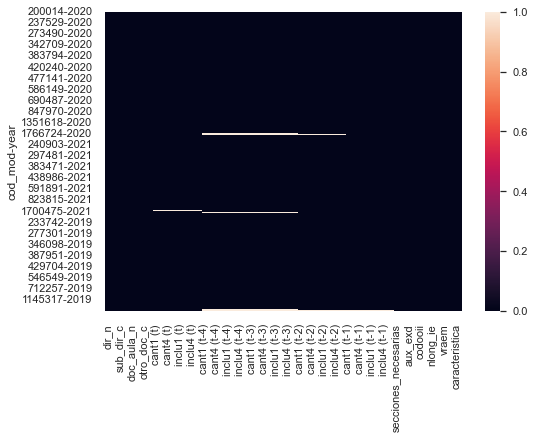

In [381]:
# Inspecting missing
import seaborn as sns
sns.heatmap(df_primaria.isnull())

<AxesSubplot:ylabel='cod_mod-year'>

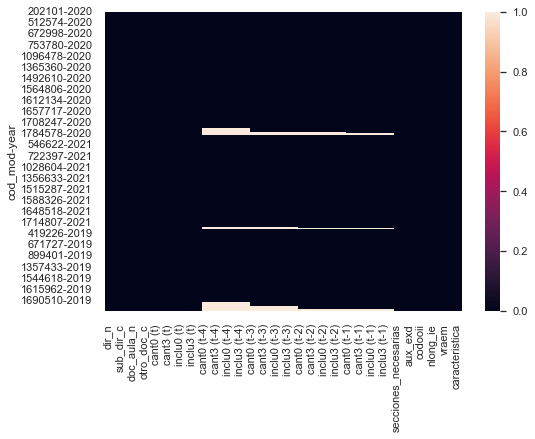

In [382]:
# Inspecting missing
sns.heatmap(df_inicial.isnull())

In [383]:
# Imputing missing
df_primaria.fillna(0,inplace=True)
df_inicial.fillna(0,inplace=True)

### Feature selection

#### Build total labor force and growth enrollment

In [384]:
def build_labor(df,nivel):
    """Function to build important features in labor force and enrollment 

    Args:
        df (DataFrame): DataFrame to build feature
        nivel (String): String of the level education

    Returns:
        DataFrame: DataFrame with the new features
    """

    # Labor force
    df['Directores'] = df['dir_n'] + df['dir_c']
    df['Subdirectores'] = df['sub_dir_n'] + df['sub_dir_c']
    df['Jerarquicos'] = df['jer_n'] + df['jer_c']
    df['Docentes de aula'] = df['doc_aula_n'] + df['doc_aula_c']
    df['Otros docentes'] = df['otro_doc_n'] + df['otro_doc_c']
    df['Auxiliares'] = df['aux_n'] + df['aux_c']
    df['Otro personal'] = df['Directores']+df['Subdirectores']+df['Jerarquicos']+df['Auxiliares']+df['Otros docentes']

    # Enrollment
    periodos = ['t','t-1','t-2','t-3','t-4']
    # Total Enrollment
    if nivel=='inicial':
        for i in periodos:
            df[f'Matricula regular total {i}']=df[f'cant0 ({i})']+df[f'cant1 ({i})']+df[f'cant2 ({i})']+df[f'cant3 ({i})']+df[f'cant4 ({i})']+df[f'cant5 ({i})']
            df[f'Matricula inclusiva total {i}']=df[f'inclu0 ({i})']+df[f'inclu1 ({i})']+df[f'inclu2 ({i})']+df[f'inclu3 ({i})']+df[f'inclu4 ({i})']+df[f'inclu5 ({i})']
    else:
        for i in periodos:
            df[f'Matricula regular total {i}']=df[f'cant1 ({i})']+df[f'cant2 ({i})']+df[f'cant3 ({i})']+df[f'cant4 ({i})']+df[f'cant5 ({i})']+df[f'cant6 ({i})']
            df[f'Matricula inclusiva total {i}']=df[f'inclu1 ({i})']+df[f'inclu2 ({i})']+df[f'inclu3 ({i})']+df[f'inclu4 ({i})']+df[f'inclu5 ({i})']+df[f'inclu6 ({i})']

    # Growth rate enrollment
    # Method 1
    #df_primaria["tasa_c_anual_regular"]=((df_primaria['Matricula regular total t']/df_primaria['Matricula regular total t-4'])**(1/4))-1
    #df_primaria["tasa_c_anual_inclusivo"]=((df_primaria['Matricula inclusiva total t']/df_primaria['Matricula inclusiva total t-4'])**(1/4))-1
    # Method 2
    df['tasa_c_anual_regular'] = ((df['Matricula regular total t']-df['Matricula regular total t-1'])+
                                            (df['Matricula regular total t-1']-df['Matricula regular total t-2'])+
                                            (df['Matricula regular total t-3']-df['Matricula regular total t-4']))/3


    # Drop no relevant information
    df.drop(columns=['aux_exd','aux_req','jer_n','aux_n','aux_c','dir_n','dir_c','sub_dir_n','sub_dir_c', 'jer_c', 'doc_aula_n', 'doc_aula_c', 'otro_doc_n', 'otro_doc_c'],inplace=True)
    
    return df

In [385]:
df_inicial = build_labor(df_inicial,'inicial')
df_primaria = build_labor(df_primaria,'primaria')

#### Scaling the input features

In [386]:
# Drop no relevant information for encoding
df_inicial.drop(columns=['d_prov','d_dreugel','region','caracteristica'],inplace=True)
df_primaria.drop(columns=['d_prov','d_dreugel','region','caracteristica'],inplace=True)

In [387]:
# Requerimiento
    ## Inicial
inicial_req = df_inicial.loc[df_inicial['doc_aula_req']!=0]
inicial_req.drop(columns=['doc_exd'], inplace=True)
    ## Primaria
primaria_req = df_primaria.loc[df_primaria['doc_aula_req']!=0]
primaria_req.drop(columns=['doc_exd'], inplace=True)

# Excedentes
    ## Inicial
inicial_exd = df_inicial.loc[df_inicial['doc_exd']!=0]
inicial_exd.drop(columns=['doc_aula_req'], inplace=True)
    ## Primaria
primaria_exd = df_primaria.loc[df_primaria['doc_exd']!=0]
primaria_exd.drop(columns=['doc_aula_req'], inplace=True)    

In [388]:
# Inicial
inicial_num_exd = [x for x in inicial_exd.columns if inicial_exd[x].dtype!='object']
inicial_num_req = [x for x in inicial_req.columns if inicial_req[x].dtype!='object']
# Primaria
prim_num_exd = [x for x in primaria_exd.columns if primaria_exd[x].dtype!='object']
prim_num_req = [x for x in primaria_req.columns if primaria_req[x].dtype!='object']

In [389]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Inicial
inicial_exd_scaled = pd.DataFrame(scaler.fit_transform(inicial_exd[inicial_num_exd].values), columns=inicial_exd[inicial_num_exd].columns, index=inicial_exd[inicial_num_exd].index)
inicial_req_scaled = pd.DataFrame(scaler.fit_transform(inicial_req[inicial_num_req].values), columns=inicial_req[inicial_num_req].columns, index=inicial_req[inicial_num_req].index)
# Primaria
primaria_exd_scaled = pd.DataFrame(scaler.fit_transform(primaria_exd[prim_num_exd].values), columns=primaria_exd[prim_num_exd].columns, index=primaria_exd[prim_num_exd].index)
primaria_req_scaled = pd.DataFrame(scaler.fit_transform(primaria_req[prim_num_req].values), columns=primaria_req[prim_num_req].columns, index=primaria_req[prim_num_req].index)

#### Encoding categorical variable

In [390]:
# Inicial
inicial_str_exd = [x for x in inicial_exd.columns if inicial_exd[x].dtype=='object']
inicial_str_req = [x for x in inicial_req.columns if inicial_req[x].dtype=='object']
# Primaria
primaria_str_exd = [x for x in primaria_exd.columns if primaria_exd[x].dtype=='object']
primaria_str_req = [x for x in primaria_req.columns if primaria_req[x].dtype=='object']

In [391]:
def encoding_str(df, list_str):
    """Generate a new DataFrame with encoding string columns 

    Args:
        df (DataFrame): The original DataFrame
        list_str (List): List of string columns to encoding
    """
    new_df = pd.get_dummies(df[list_str])
    new_df.drop(columns=['frontera_No frontera', 'bilingue_No bilingue','vraem_No Vraem','ruralidad_Urbano'],inplace=True)
    return new_df

In [392]:
# Inicial
oh_inicial_exd = encoding_str(inicial_exd,inicial_str_exd)
oh_inicial_req = encoding_str(inicial_req,inicial_str_req)

# Primaria
oh_prim_exd = encoding_str(primaria_exd,primaria_str_exd)
oh_prim_req = encoding_str(primaria_req,primaria_str_req)

In [393]:
# Join with the dataframe scaler
    #Inicial
inicial_exd_clean = pd.merge(left=inicial_exd_scaled, right=oh_inicial_exd, left_index=True, right_index=True)
inicial_req_clean = pd.merge(left=inicial_req_scaled, right=oh_inicial_req, left_index=True, right_index=True)
    #Primaria
prim_exd_clean = pd.merge(left=primaria_exd_scaled , right=oh_prim_exd, left_index=True, right_index=True)
prim_req_clean = pd.merge(left=primaria_req_scaled , right=oh_prim_req, left_index=True, right_index=True)


### Finding optimal clusters

In [394]:
# Determino la cantidad de clusters
from sklearn.cluster import KMeans

In [395]:
#Inicial
inicial_req_knn = inicial_req_clean.copy()
inicial_exd_knn = inicial_exd_clean.copy()
#Primaria
primaria_req_knn = prim_req_clean.copy()
primaria_exd_knn = prim_exd_clean.copy()

Metodo 1: Visual

In [396]:
def visualizer_elbow(df,n_clusters=2,seed=36963):
    """Plot the Elbow method

    Args:
        df (_type_): _description_
        n_clusters (int, optional): _description_. Defaults to 2.
        seed (int, optional): _description_. Defaults to 36963.
    """
    wcss = []
    for i in range(1,n_clusters):
        kmeans = KMeans(n_clusters=i,init='k-means++',random_state=seed)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        
    # Graficaremos lva evalución de la varianza intra-clusters
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
    ax.plot(range(1,n_clusters), wcss, marker='o')
    ax.set_title("Evolución de la varianza intra-cluster total")
    ax.set_xlabel('Número clusters')
    ax.set_ylabel('Intra-cluster (inertia)')
    my_elbow = plt.plot(range(1,n_clusters),wcss)

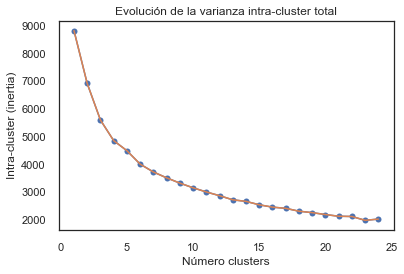

In [397]:
visualizer_elbow(inicial_req_knn,25)

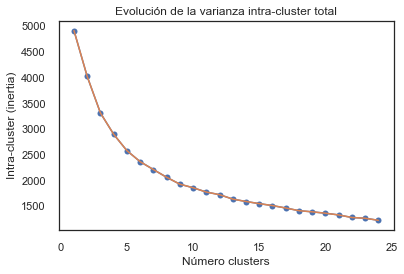

In [398]:
visualizer_elbow(inicial_exd_knn,25)

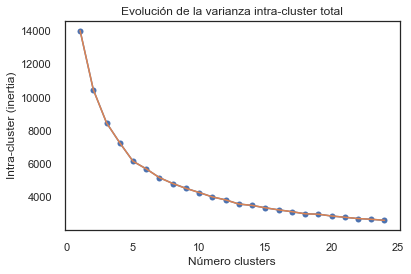

In [399]:
visualizer_elbow(primaria_req_knn,25)

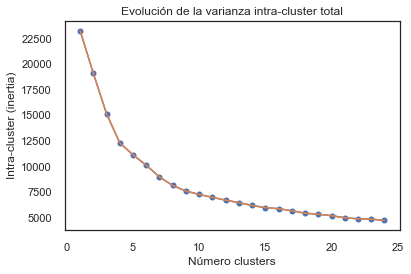

In [400]:
visualizer_elbow(primaria_exd_knn,25)

Metodo 2: Usar la libreria yellowbrick

In [401]:
#pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

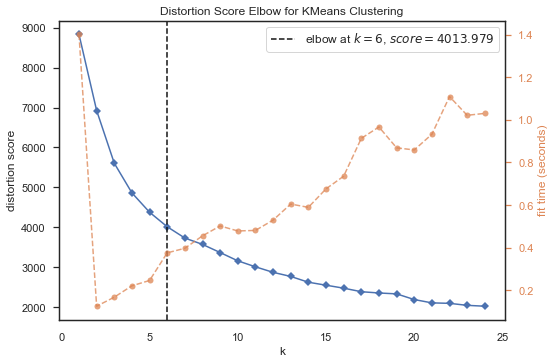

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [402]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,25))
visualizer.fit(inicial_req_knn)        
visualizer.show() 

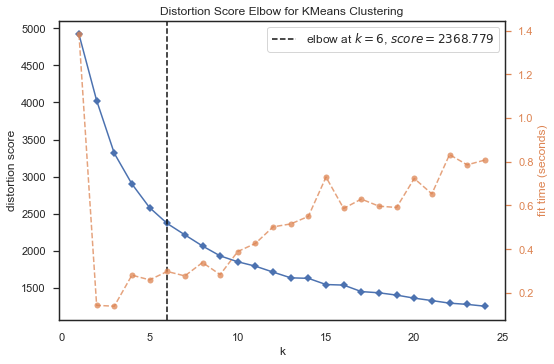

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [403]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,25))
visualizer.fit(inicial_exd_knn)        
visualizer.show() 

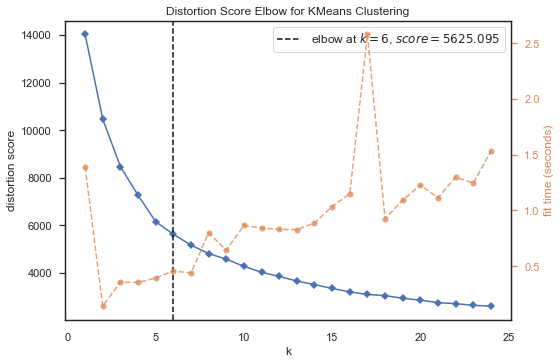

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [404]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,25))
visualizer.fit(primaria_req_knn)        
visualizer.show() 

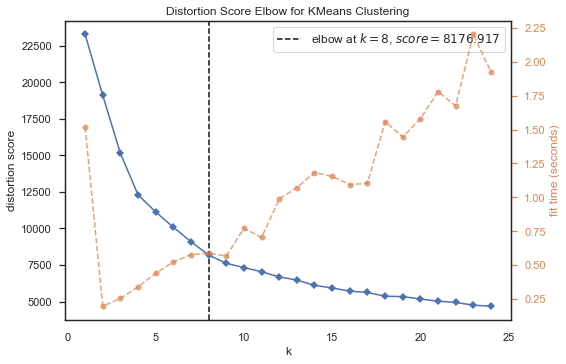

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [405]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,25))
visualizer.fit(primaria_exd_knn)        
visualizer.show() 

Resumen de los clusters optimos:

- Inicial
    - Para requerimientos: 6 clusters
    - Para excedentes: 6 clusters

- Primaria
    - Para requerimientos: 6 clusters
    - Para excedentes: 7 clusters

In [406]:
def build_clusters(df_to_fit,n_clusters,df_original,random_state=36963):
    """Return a Data Frame with the column Clusters into the orginal DataFrame. This column indicate the number of clusters into the DataFrame

    Args:
        df_to_fit (DataFrame): The DataFrame to fit and predict
        n_clusters (Int): The numbers of clusters
        df_original (DataFrame): The DataFrame without scaling or encoding (The original DataFrame)
        random_state (Int): The seed to replicate
    """
    # Fit the model
    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=random_state)
    kmeans.fit(df_to_fit)

    # Predict in the original sample
    clusters = kmeans.predict(df_to_fit)
    df_to_fit['Clusters'] = clusters

    # Include the clusters into original DataFrame
    df = pd.merge(left=df_original, right=df_to_fit[['Clusters']],  left_index=True , right_index=True)
    return df

In [407]:
#Inicial
df_req_inicial_clusters = build_clusters(inicial_req_knn,6, inicial_req)
df_exd_inicial_clusters = build_clusters(inicial_exd_knn,6, inicial_exd)

#Primaria
df_req_prim_clusters = build_clusters(primaria_req_knn,6,primaria_req)
df_exd_prim_clusters = build_clusters(primaria_exd_knn,7,primaria_exd)

### Inspecting clusters

In [408]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set_theme(style="white")

Resumen

In [409]:
def resumen_clusters(df,estado):

    # Matricula
    ## Construyo la base para el grafico de lineas
    for i in ['t','t-1','t-2','t-3','t-4']:
        df[f'Matricula total {i}'] = df[f'Matricula regular total {i}'] + df[f'Matricula inclusiva total {i}']
    df_line = pd.melt(df, id_vars=['Clusters'], value_vars=['Matricula total t','Matricula total t-1','Matricula total t-2','Matricula total t-3', 'Matricula total t-4'])    
    df_line.sort_values(by="variable", inplace=True, ascending=False)
    ## Hago el grafico de linea
    for i in ['t','t-1','t-2','t-3','t-4']:
        df_line.loc[df_line['variable']==f'Matricula total {i}', 'variable' ] = f'{i}'
    fig1  = sns.lineplot(x="variable", y="value", hue="Clusters",data=df_line)
    plt.title('Evolucion de la matricula, por clusters')
    plt.xlabel('Años')
    plt.ylabel('Cantidad de alumnos matriculados')
    #fig1.legend(labels=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7','Cluster 8'])
    plt.show()

    # Personal
    fig2 = sns.scatterplot(data=df, x='Docentes de aula', y='Otro personal', hue='Clusters',size=estado)
    plt.title('Personal, por grupo')
    #fig2.legend(labels=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7','Cluster 8'])
    plt.show()

    # Otras caracteristicas
    df_otros = pd.get_dummies(df)
    df_otros = df_otros.groupby('Clusters',as_index=False)['ruralidad_Rural 1', 'ruralidad_Rural 2', 'ruralidad_Rural 3', 'ruralidad_Urbano', 'vraem_Vraem', 'frontera_Frontera','bilingue_Bilingue'].sum()
    df_otros.rename(columns={'ruralidad_Rural 1'  : 'Rural 1', 
                            'ruralidad_Rural 2' : 'Rural 2', 
                            'ruralidad_Rural 3' : 'Rural 3', 
                            'ruralidad_Urbano'  : 'Urbano',
                            'vraem_Vraem'       : 'Vraem',
                            'frontera_Frontera' : 'Frontera',
                            'bilingue_Bilingue' : 'Bilingue'}, inplace=True)

    #df_otros['Clusters'] = df_otros['Clusters'] + 1
    print(df_otros)

    return fig1,fig2, df_otros
    

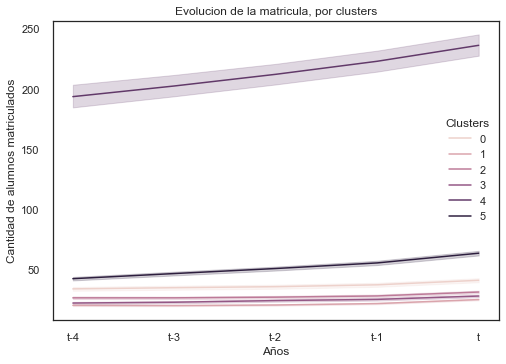

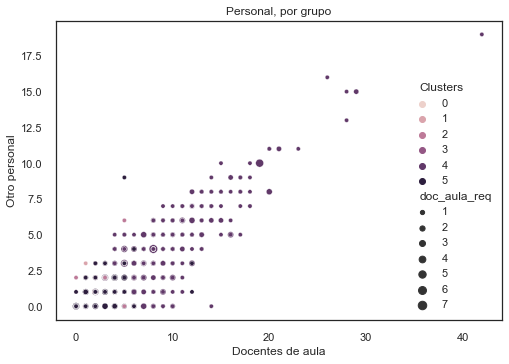

   Clusters  Rural 1  Rural 2  Rural 3  Urbano  Vraem  Frontera  Bilingue
0         0      0.0      0.0    955.0     0.0   22.0      57.0      77.0
1         1   1462.0      0.0      0.0     0.0  153.0     119.0       0.0
2         2      0.0   1651.0      0.0     0.0   85.0     124.0     318.0
3         3    689.0      0.0      0.0     3.0  114.0     126.0     692.0
4         4      0.0      0.0      0.0   513.0    7.0      28.0       1.0
5         5      0.0      0.0      0.0  1866.0   48.0      57.0       2.0


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_24640\2904691025.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_otros = df_otros.groupby('Clusters',as_index=False)['ruralidad_Rural 1', 'ruralidad_Rural 2', 'ruralidad_Rural 3', 'ruralidad_Urbano', 'vraem_Vraem', 'frontera_Frontera','bilingue_Bilingue'].sum()


In [410]:
graph1, graph12, tabla = resumen_clusters(df_req_inicial_clusters,'doc_aula_req')

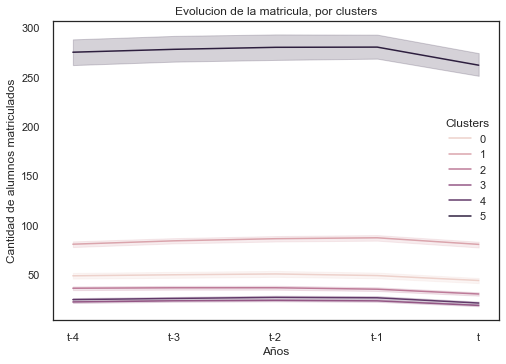

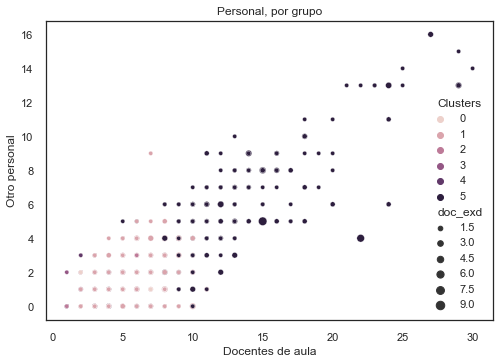

   Clusters  Rural 1  Rural 2  Rural 3  Urbano  Vraem  Frontera  Bilingue
0         0      0.0      0.0    447.0     0.0    8.0      40.0      48.0
1         1      0.0      0.0      0.0  1118.0   21.0      72.0       4.0
2         2      0.0    762.0      0.0     0.0   23.0      68.0     184.0
3         3    550.0      0.0      0.0     0.0   26.0      48.0       0.0
4         4    331.0      0.0      0.0     0.0   23.0      63.0     331.0
5         5      0.0      0.0      0.0   303.0    4.0      14.0       0.0


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_24640\2904691025.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_otros = df_otros.groupby('Clusters',as_index=False)['ruralidad_Rural 1', 'ruralidad_Rural 2', 'ruralidad_Rural 3', 'ruralidad_Urbano', 'vraem_Vraem', 'frontera_Frontera','bilingue_Bilingue'].sum()


In [411]:
graph1, graph12, tabla = resumen_clusters(df_exd_inicial_clusters,'doc_exd')

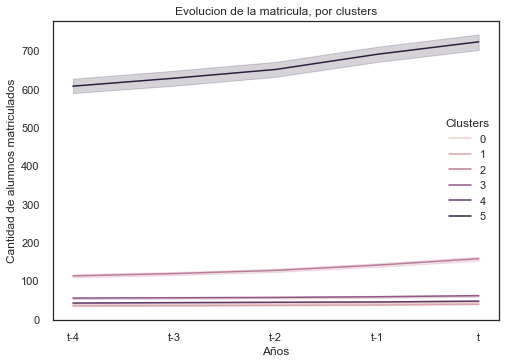

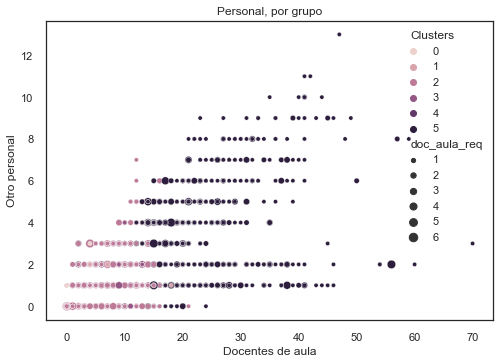

   Clusters  Rural 1  Rural 2  Rural 3  Urbano  Vraem  Frontera  Bilingue
0         0    768.0      0.0      0.0     7.0    0.0     775.0     422.0
1         1   2950.0      0.0      0.0     0.0  177.0       0.0       0.0
2         2      0.0      0.0    785.0  1132.0   27.0      65.0      47.0
3         3      0.0   1980.0      0.0     0.0   67.0     136.0     314.0
4         4   1122.0      0.0      0.0     4.0  213.0       0.0    1126.0
5         5      0.0      3.0      3.0   721.0    5.0      51.0       0.0


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_24640\2904691025.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_otros = df_otros.groupby('Clusters',as_index=False)['ruralidad_Rural 1', 'ruralidad_Rural 2', 'ruralidad_Rural 3', 'ruralidad_Urbano', 'vraem_Vraem', 'frontera_Frontera','bilingue_Bilingue'].sum()


In [412]:
graph1, graph12, tabla = resumen_clusters(df_req_prim_clusters,'doc_aula_req')

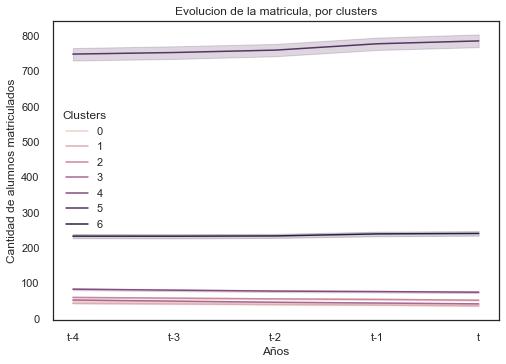

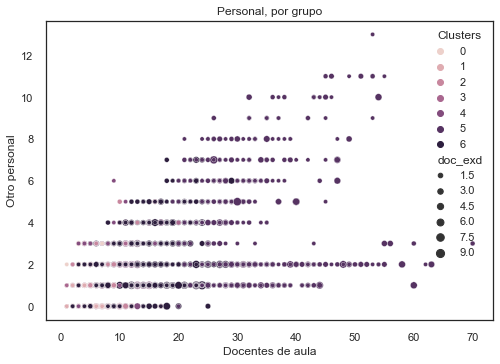

   Clusters  Rural 1  Rural 2  Rural 3  Urbano  Vraem  Frontera  Bilingue
0         0   1614.0      0.0      0.0     3.0  169.0     178.0    1617.0
1         1   2337.0      0.0      0.0     0.0  120.0     102.0       0.0
2         2      0.0   2643.0      0.0     0.0   73.0     275.0       0.0
3         3      0.0   1827.0      0.0     2.0   82.0     316.0    1829.0
4         4      0.0      0.0   2244.0     0.0   74.0     463.0     480.0
5         5      0.0      0.0      1.0   716.0    8.0      40.0       0.0
6         6      0.0      3.0      2.0  1803.0   50.0     139.0       4.0


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_24640\2904691025.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_otros = df_otros.groupby('Clusters',as_index=False)['ruralidad_Rural 1', 'ruralidad_Rural 2', 'ruralidad_Rural 3', 'ruralidad_Urbano', 'vraem_Vraem', 'frontera_Frontera','bilingue_Bilingue'].sum()


In [413]:
graph1, graph12, tabla = resumen_clusters(df_exd_prim_clusters,'doc_exd')

#### Enrrollment

In [414]:
for i in ['t','t-1','t-2','t-3','t-4']:
    df_req_prim_clusters[f'Matricula total {i}'] = df_req_prim_clusters[f'Matricula regular total {i}'] + df_req_prim_clusters[f'Matricula inclusiva total {i}']

In [415]:
df_line = pd.melt(df_req_prim_clusters, id_vars=['Clusters'], value_vars=['Matricula total t','Matricula total t-1','Matricula total t-2','Matricula total t-3', 'Matricula total t-4'])

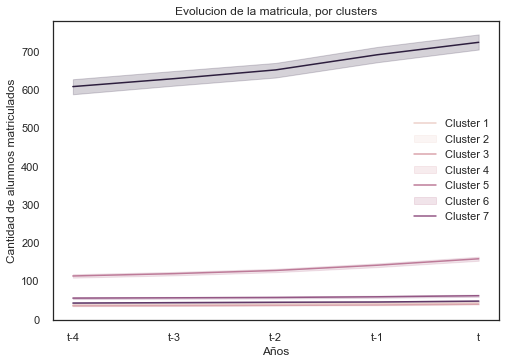

In [416]:
df_line.sort_values(by="variable", inplace=True, ascending=False)

for i in ['t','t-1','t-2','t-3','t-4']:
    df_line.loc[df_line['variable']==f'Matricula total {i}', 'variable' ] = f'{i}'

fig  = sns.lineplot(x="variable", y="value", hue="Clusters",data=df_line)
plt.title('Evolucion de la matricula, por clusters')
plt.xlabel('Años')
plt.ylabel('Cantidad de alumnos matriculados')
fig.legend(labels=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7',])

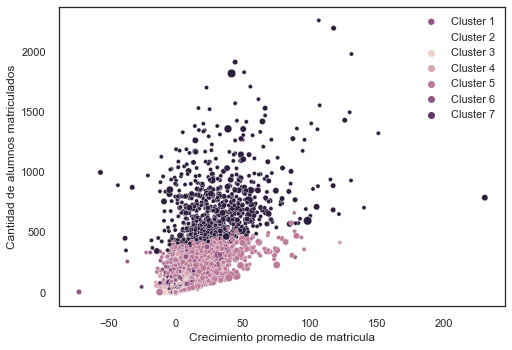

In [417]:
fig = sns.scatterplot(data=df_req_prim_clusters, x='tasa_c_anual_regular', y='Matricula regular total t', hue='Clusters',size="doc_aula_req")
#plt.xscale('log')
#plt.yscale('log')
#plt.title('Muermo')
plt.xlabel('Crecimiento promedio de matricula')
plt.ylabel('Cantidad de alumnos matriculados')
fig.legend(labels=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7',])
plt.show()

In [418]:
#for i in range(7):
#    print(f'Cluster {i}')
#    df = df_req_prim_clusters.loc[df_req_prim_clusters['Clusters']==i, ['Matricula total t','Matricula total t-1','Matricula total t-2','Matricula total t-3','Matricula total t-4']].describe().transpose()
#    print(df)
#    print('\n')

#### Labor force

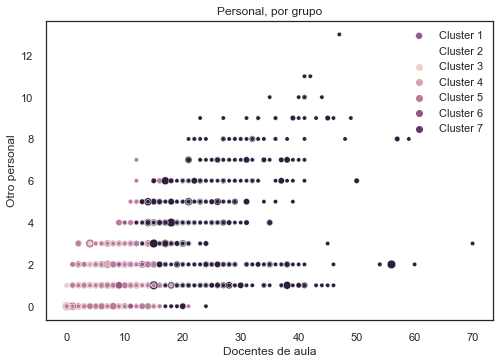

In [419]:
fig = sns.scatterplot(data=df_req_prim_clusters, x='Docentes de aula', y='Otro personal', hue='Clusters',size="doc_aula_req")
plt.title('Personal, por grupo')
fig.legend(labels=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7',])
plt.show()

In [420]:
#for i in ['Directores', 'Subdirectores','Docentes de aula','Otros docentes']:
#    print(sns.boxplot(x= 'Clusters', y=f'{i}', data=df_req_prim_clusters, palette=["m", "g"],showfliers = False))
#    plt.figure()

In [421]:
#for i in range(7):
#    print(f'Cluster {i}')
#    df = df_req_prim_clusters.loc[df_req_prim_clusters['Clusters']==i, ['Directores', 'Subdirectores','Docentes de aula','Otros docentes']].describe().transpose()
#    print(df)
#    print('\n')

#### Othe features

In [422]:
df = pd.get_dummies(df_req_prim_clusters)

In [423]:
others = df.groupby('Clusters',as_index=False)['ruralidad_Rural 1', 'ruralidad_Rural 2', 'ruralidad_Rural 3', 'ruralidad_Urbano', 'vraem_Vraem', 'frontera_Frontera','bilingue_Bilingue'].sum()

others.rename(columns={'ruralidad_Rural 1'  : 'Rural 1', 
                        'ruralidad_Rural 2' : 'Rural 2', 
                        'ruralidad_Rural 3' : 'Rural 3', 
                        'ruralidad_Urbano'  : 'Urbano',
                        'vraem_Vraem'       : 'Vraem',
                        'frontera_Frontera' : 'Frontera',
                        'bilingue_Bilingue' : 'Bilingue'}, inplace=True)

others['Clusters'] = others['Clusters'] + 1
others

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_24640\306756897.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  others = df.groupby('Clusters',as_index=False)['ruralidad_Rural 1', 'ruralidad_Rural 2', 'ruralidad_Rural 3', 'ruralidad_Urbano', 'vraem_Vraem', 'frontera_Frontera','bilingue_Bilingue'].sum()


,Clusters,Rural 1,Rural 2,Rural 3,Urbano,Vraem,Frontera,Bilingue
0,1,768.0,0.0,0.0,7.0,0.0,775.0,422.0
1,2,2950.0,0.0,0.0,0.0,177.0,0.0,0.0
2,3,0.0,0.0,785.0,1132.0,27.0,65.0,47.0
3,4,0.0,1980.0,0.0,0.0,67.0,136.0,314.0
4,5,1122.0,0.0,0.0,4.0,213.0,0.0,1126.0
5,6,0.0,3.0,3.0,721.0,5.0,51.0,0.0
